In [1]:
import os
import numpy as np
import math 

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

import matplotlib.pyplot as plt
from pydub import AudioSegment
import librosa
from sklearn.preprocessing import minmax_scale
import emd
import time

In [2]:
# TODO: modify below path when needed
RAW_DATASET_PATH = os.path.join("..", "animal_sounds")
DATASET_AUDIO_PATH = os.path.join("..", "animal_sounds_clips")
# The sampling rate to use.
# This is the one used in all of the audio samples.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000
# percentage of recordings used for validation
TEST_RATIO = 0.05
CLIP_LEN = 500

In [3]:
def prepare_data():
    if not os.path.exists(DATASET_AUDIO_PATH):
        os.makedirs(DATASET_AUDIO_PATH)

    for class_name in os.listdir(RAW_DATASET_PATH):
        before = 0
        after = 0
        files = os.listdir(os.path.join(RAW_DATASET_PATH, class_name))
        for file in files:
            if before < TEST_RATIO * len(files):
                target_path = os.path.join(DATASET_AUDIO_PATH, class_name[:-2]+"_valid")
            else:
                target_path = os.path.join(DATASET_AUDIO_PATH, class_name[:-2])
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            p = os.path.join(RAW_DATASET_PATH, class_name, file)
            try:
                audio = AudioSegment.from_wav(p)
                audio = audio.set_frame_rate(SAMPLING_RATE)
            except:
                print(f"Could not load file {p}. Skipping.")
                continue
            before += 1
            step = math.floor(CLIP_LEN / 2.5) if class_name.startswith("kidney") or class_name.startswith("muscle") else CLIP_LEN // 2
            for t in range(3000, len(audio)-CLIP_LEN, step):
                after += 1
                new_audio = audio[t:t+CLIP_LEN]
                split = os.path.splitext(file)
                filename = split[0] + f"_{after}_{class_name}" + split[1]
                new_audio.export(os.path.join(target_path, filename),
                                format="wav", parameters=["-sample_fmt", "s16"])
        print(f"{class_name}: Split {before} tracks into {after} clips of length {CLIP_LEN/1000}s")

prepare_data() # this needs to be run just once

animal_ribs_1: Split 53 tracks into 78 clips of length 0.5s
Could not load file ..\animal_sounds\kidney_animal_1\REC67.WAV. Skipping.
kidney_animal_1: Split 45 tracks into 149 clips of length 0.5s
kidney_animal_2: Split 51 tracks into 276 clips of length 0.5s
liver_animal 2: Split 57 tracks into 629 clips of length 0.5s
Could not load file ..\animal_sounds\liver_animal_1\REC103.WAV. Skipping.
Could not load file ..\animal_sounds\liver_animal_1\REC107.WAV. Skipping.
liver_animal_1: Split 42 tracks into 268 clips of length 0.5s
Could not load file ..\animal_sounds\muscle_animal_1\REC77.WAV. Skipping.
muscle_animal_1: Split 46 tracks into 122 clips of length 0.5s
muscle_animal_2: Split 59 tracks into 268 clips of length 0.5s
Could not load file ..\animal_sounds\ribs_animal_2\REC83.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\REC85.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\REC89.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\R

In [4]:
# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 5123
BATCH_SIZE = 128
EPOCHS = 1 # TODO
# tf.config.run_functions_eagerly(True) # to make conversions before training possible
# tf.constant([1,2,3]).numpy()

In [67]:
def paths_and_labels_to_dataset(audio_paths, labels):
    # TODO
    audio_paths = audio_paths[:1]
    labels = labels[:1]
    """Constructs a dataset of audios and labels."""
    
    audios = [audio_to_imfs(path_to_audio(path)) for path in audio_paths]
    # audios = [audio_to_mfccs(path_to_audio(path)) for path in audio_paths]
    # audios = [join(audio_to_imfs(path_to_audio(path)), audio_to_centroids(path_to_audio(path))) for path in audio_paths]
    audio_ds = tf.data.Dataset.from_tensor_slices(audios)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio.numpy()

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def join(array_1, array_2):
    return np.concatenate((array_1, array_2))

def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

# TODO: below functions can be used as replacement/addition to audio_to_fft. Call them in analogous way
def audio_to_mfccs(audio):
    return librosa.feature.mfcc(y=audio, sr=SAMPLING_RATE, n_fft=len(audio) // 2).flatten()

def audio_to_centroids(audio):
    audio_length = len(audio)
    centroids = librosa.feature.spectral_centroid(y=audio, sr=SAMPLING_RATE, n_fft=audio_length // 2, hop_length=audio_length // 10)[0]
    return centroids
    # return normalize(centroids) # normalization does not make sense at interval
    
def audio_to_imfs(audio):
    imfs = emd.sift.sift(audio)
    return imfs

# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

train_audio_paths = []
valid_audio_paths = []
train_labels = []
valid_labels = []
for label, name in enumerate(class_names):
    print("Processing material {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.lower().endswith(".wav")
    ]
    label = label // 2 # coz every dir has a _valid copy
    if name.endswith("_valid"):
        valid_audio_paths += speaker_sample_paths
        valid_labels += [label] * len(speaker_sample_paths)
    else:
        train_audio_paths += speaker_sample_paths
        train_labels += [label] * len(speaker_sample_paths)
    print(f"Loaded {len(speaker_sample_paths)} files from class {label}.")
    
print(
    "Found {} files belonging to {} classes.".format(len(train_audio_paths) + len(valid_audio_paths), len(class_names)//2)
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(valid_audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_labels)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(valid_labels)

print("Using {} files for training.".format(len(train_labels)))
print("Using {} files for validation.".format(len(valid_labels)))

# Create 2 datasets, one for training and the other for validation

start = time.time()
train_audio_paths = train_audio_paths[:]
valid_audio_paths = valid_audio_paths[:]

train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.map(lambda x, y: (tf.reshape(x, (1, x.shape[0])), y))
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)


end = time.time()
elapsed = end - start

print(f"finished preparing training dataset : {elapsed:.2f}")

start = time.time()

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.map(lambda x, y: (tf.reshape(x, (1, x.shape[0])), y))
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

# end = time.time()
# elapsed = end - start

# print(f"finished preparing validation dataset : {elapsed:.2f}")

# # Transform audio wave to the frequency domain using `audio_to_fft`
# # train_ds = train_ds.map(
# #     lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
# # )
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# # valid_ds = valid_ds.map(
# #     lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
# # )
# valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)


Our class names: ['animal_ribs', 'animal_ribs_valid', 'kidney_animal', 'kidney_animal_valid', 'liver_animal', 'liver_animal_valid', 'muscle_animal', 'muscle_animal_valid', 'ribs_animal', 'ribs_animal_valid', 'skin_animal', 'skin_animal_valid']
Processing material animal_ribs
Loaded 69 files from class 0.
Processing material animal_ribs_valid
Loaded 9 files from class 0.
Processing material kidney_animal
Loaded 401 files from class 1.
Processing material kidney_animal_valid
Loaded 24 files from class 1.
Processing material liver_animal
Loaded 860 files from class 2.
Processing material liver_animal_valid
Loaded 37 files from class 2.
Processing material muscle_animal
Loaded 373 files from class 3.
Processing material muscle_animal_valid
Loaded 17 files from class 3.
Processing material ribs_animal
Loaded 368 files from class 4.
Processing material ribs_animal_valid
Loaded 6 files from class 4.
Processing material skin_animal
Loaded 868 files from class 5.
Processing material skin_animal

C:\Users\HP\AppData\Local\pypoetry\Cache\virtualenvs\projekt-NJWmLhMO-py3.10\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(128, 1, 16000)
finished preparing training dataset : 460.36


In [53]:
print(list(train_ds.take(1))[0][0].shape)

(1, 1, 16000)


In [68]:
def residual_block(x, filters, conv_num=3, activation="relu", is_first=False):
    # Shortcut
    # if is_first:
    #     s = keras.layers.Conv1D(filters, 3, padding="same", input_shape=(SAMPLING_RATE,))(x)
    # else:
    s = keras.layers.Conv1D(filters, 3, padding="same")(x)
    for i in range(conv_num - 1):
        # if i == 0 and is_first:
        #     x = keras.layers.Conv1D(filters, 3, padding="same", input_shape=(SAMPLING_RATE,))(x)
        # else:
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=1, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2, is_first=True)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=1, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


input_shape = ()
model = build_model((1,SAMPLING_RATE), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "my_best_model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1, 16000)]   0           []                               
                                                                                                  
 conv1d_74 (Conv1D)             (None, 1, 16)        768016      ['input[0][0]']                  
                                                                                                  
 activation_46 (Activation)     (None, 1, 16)        0           ['conv1d_74[0][0]']              
                                                                                                  
 conv1d_75 (Conv1D)             (None, 1, 16)        784         ['activation_46[0][0]']          
                                                                                            

In [69]:
# CHECKPOINT_PATH = Path("my_best_model.h5")
# history = None
# if os.path.exists(CHECKPOINT_PATH):
#     model.load_weights(CHECKPOINT_PATH)
# else:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
23/23 [==============================] - 8s 342ms/step - loss: 67.2543 - accuracy: 0.1892 - val_loss: 29.5505 - val_accuracy: 0.2477
Epoch 2/100
23/23 [==============================] - 7s 316ms/step - loss: 18.3480 - accuracy: 0.2198 - val_loss: 12.6929 - val_accuracy: 0.3394
Epoch 3/100
23/23 [==============================] - 6s 281ms/step - loss: 7.7216 - accuracy: 0.2617 - val_loss: 3.1727 - val_accuracy: 0.2018
Epoch 4/100
23/23 [==============================] - 7s 284ms/step - loss: 7.4007 - accuracy: 0.2623 - val_loss: 3.5764 - val_accuracy: 0.3486
Epoch 5/100
23/23 [==============================] - 7s 299ms/step - loss: 4.6935 - accuracy: 0.2688 - val_loss: 2.8039 - val_accuracy: 0.3578
Epoch 6/100
23/23 [==============================] - 7s 296ms/step - loss: 4.5792 - accuracy: 0.2872 - val_loss: 2.4125 - val_accuracy: 0.1560
Epoch 7/100
23/23 [==============================] - 7s 297ms/step - loss: 4.2906 - accuracy: 0.2848 - val_loss: 2.6676 - val_accuracy: 0.

23/23 [==============================] - 7s 293ms/step - loss: 1.6373 - accuracy: 0.2930 - val_loss: 1.7967 - val_accuracy: 0.1376
Epoch 50/100
23/23 [==============================] - 7s 285ms/step - loss: 1.6207 - accuracy: 0.2943 - val_loss: 1.7933 - val_accuracy: 0.2936
Epoch 51/100
23/23 [==============================] - 6s 282ms/step - loss: 1.6358 - accuracy: 0.2998 - val_loss: 1.8037 - val_accuracy: 0.1468
Epoch 52/100
23/23 [==============================] - 7s 299ms/step - loss: 1.6156 - accuracy: 0.3011 - val_loss: 1.7958 - val_accuracy: 0.3028
Epoch 53/100
23/23 [==============================] - 7s 285ms/step - loss: 1.6114 - accuracy: 0.2981 - val_loss: 1.7738 - val_accuracy: 0.3119
Epoch 54/100
23/23 [==============================] - 10s 435ms/step - loss: 1.6178 - accuracy: 0.2984 - val_loss: 1.7904 - val_accuracy: 0.3119
Epoch 55/100
23/23 [==============================] - 8s 342ms/step - loss: 1.6079 - accuracy: 0.3032 - val_loss: 1.7789 - val_accuracy: 0.1468
Epoc

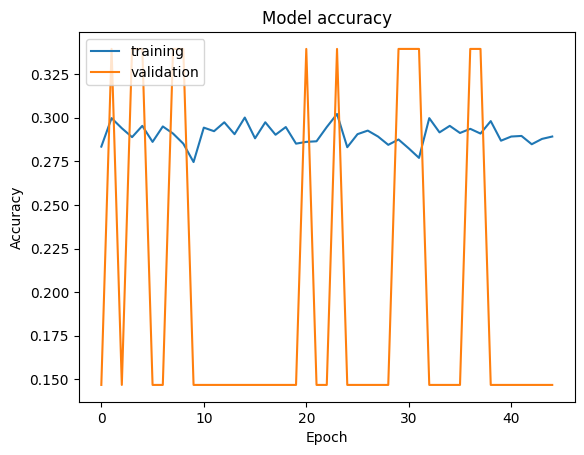

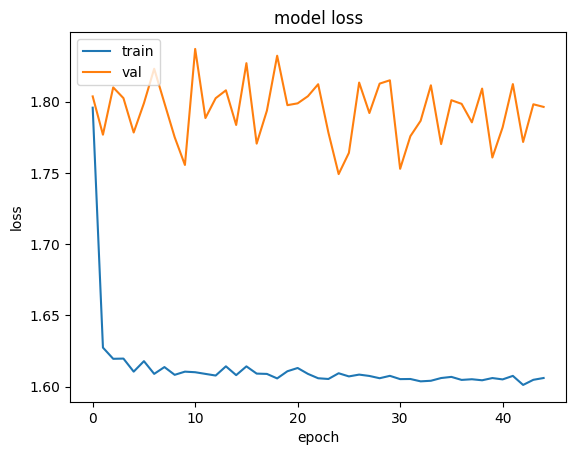

In [66]:
if history is not None:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
# SAMPLES_TO_DISPLAY = 5

# test_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
# test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
#     BATCH_SIZE
# )
# for audios, labels in test_ds.take(1):
#     # Get the signal FFT
#     ffts = audio_to_fft(audios)
#     # Predict
#     y_pred = model.predict(ffts)
#     # Take random samples
#     rnd = np.random.randint(0, len(audios), SAMPLES_TO_DISPLAY)
#     audios = audios.numpy()[rnd, :, :]
#     labels = labels.numpy()[rnd]
#     y_pred = np.argmax(y_pred, axis=-1)[rnd]

#     for index in range(SAMPLES_TO_DISPLAY):
#         # For every sample, print the true and predicted label
#         # as well as run the voice with the noise
#         print(
#             "Speaker: {} - Predicted: {}".format(
#                 class_names[labels[index]],
#                 class_names[y_pred[index]],
#             )
#         )
#         display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

In [ ]:
test_ds = paths_and_labels_to_dataset(train_audio_paths + valid_audio_paths, train_labels + valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

actual_class_names = [n for n in class_names if not n.endswith("_valid")]

confusion = np.zeros((len(actual_class_names),)*2, dtype=np.float32)
counter = 0
for audios, labels in test_ds.take(1000):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    y_pred = np.argmax(y_pred, axis=-1)
    for idx, pred in enumerate(y_pred):
        counter += 1
        confusion[labels[idx], pred] += 1

print(counter)


for idx, label in enumerate(actual_class_names):
    confusion[idx, :] /= np.sum(confusion[idx, :])
    print(f"{idx} - {label}")

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
labels = [x.split("_")[0] for x in actual_class_names]
# labels = ["ribs", "kidney", "liver", "muscle", "skin"]
df_cm = pd.DataFrame(confusion, index=labels, columns=labels)
plt.figure(figsize=(7, 5))
sn.heatmap(df_cm, annot=True, fmt=".3f", square=True, cbar=False, cmap="Blues", linewidths=3, vmin=0, vmax=1)
plt.xlabel("Predicted label", labelpad=16)
plt.ylabel("True label", labelpad=12)
plt.tick_params(axis='y', rotation=0)
plt.show()